In [31]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

In [24]:
# Data yang akan digunakan
data = {
    'Requests': [3, 6, 30, 60, 300, 600, 3000, 6000] * 2,  # Mengulang Requests untuk Kafka dan NATS
    'Broker': ['Kafka'] * 8 + ['NATS'] * 8,  # Jenis Broker
    'Throughput': [
        # Throughput untuk Kafka
        113.38, 123.66, 125.62, 126.88, 132.3, 129.73, 137.92, 141.38,
        # Throughput untuk NATS
        65.1, 114.69, 116.78, 110.55, 133.46, 128.69, 133.85, 141.64
    ]
}

# Membuat DataFrame dari data
df = pd.DataFrame(data)
df.to_csv('combined_data_throughput.csv', index=False)

In [43]:
from scipy.stats import shapiro, levene
df = pd.read_csv('./combined_data_throughput.csv')


print(df.groupby('Broker')['Throughput'].describe())
print('-----------------------END OF LINE')
print(df.groupby('Requests')['Throughput'].describe())
print('-----------------------END OF LINE')
print(df.describe())


# Uji Normalitas
print(shapiro(df['Throughput']))

# Uji Homoskedastisitas
groups = df.groupby('Broker')['Throughput'].apply(list)
print(levene(*groups))

# Siapkan model ANOVA dua arah
model = ols('Throughput ~ C(Broker) + C(Requests) + C(Broker):C(Requests)', data=df).fit()

# Hitung tabel ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Tampilkan tabel ANOVA
print(anova_table)

        count       mean        std     min      25%      50%       75%  \
Broker                                                                    
Kafka     8.0  128.85875   8.721999  113.38  125.130  128.305  133.7050   
NATS      8.0  118.09500  23.992989   65.10  113.655  122.735  133.5575   

           max  
Broker          
Kafka   141.38  
NATS    141.64  
-----------------------END OF LINE
          count     mean        std     min       25%      50%       75%  \
Requests                                                                   
3           2.0   89.240  34.139115   65.10   77.1700   89.240  101.3100   
6           2.0  119.175   6.342748  114.69  116.9325  119.175  121.4175   
30          2.0  121.200   6.250824  116.78  118.9900  121.200  123.4100   
60          2.0  118.715  11.547054  110.55  114.6325  118.715  122.7975   
300         2.0  132.880   0.820244  132.30  132.5900  132.880  133.1700   
600         2.0  129.210   0.735391  128.69  128.9500  129.210  

D:\..SKRIPSI\CALCULATION\e2e-latency\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ValueError: array must not contain infs or NaNs

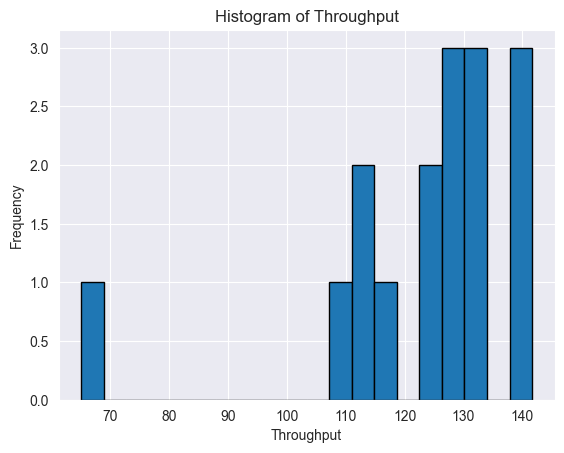

In [47]:
import matplotlib.pyplot as plt

plt.hist(df['Throughput'], bins=20, edgecolor='k')
plt.title('Histogram of Throughput')
plt.xlabel('Throughput')
plt.ylabel('Frequency')
plt.show()

In [52]:
from scipy.stats import shapiro

shapiro_test = shapiro(df['Throughput'])
print('Shapiro-Wilk test:', shapiro_test)

from scipy import stats

# Terapkan transformasi Box-Cox
df['Throughput_boxcox'], _ = stats.boxcox(df['Throughput'] + 1)  # Menambahkan 1 untuk menghindari masalah dengan nilai 0

# Lakukan uji Shapiro-Wilk lagi pada data yang telah ditransformasi
shapiro_test_boxcox = shapiro(df['Throughput_boxcox'])
print('Shapiro-Wilk test (Box-Cox-transformed):', shapiro_test_boxcox)




Shapiro-Wilk test: ShapiroResult(statistic=np.float64(0.7724326063360012), pvalue=np.float64(0.0011994275960621266))
Shapiro-Wilk test (Box-Cox-transformed): ShapiroResult(statistic=np.float64(0.973152919639874), pvalue=np.float64(0.8867276731398035))


In [58]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox, shapiro
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Baca data dari CSV
df = pd.read_csv('./combined_data_throughput.csv')

# Pastikan kolom Throughput memiliki tipe data numerik
df['Throughput'] = pd.to_numeric(df['Throughput'], errors='coerce')

# Periksa apakah ada nilai nol atau negatif dalam Throughput
if (df['Throughput'] <= 0).any():
    print("Data contains non-positive values. Please check the data.")
else:
    # Terapkan transformasi Box-Cox
    df['Throughput_boxcox'], _ = boxcox(df['Throughput'] + 1)  # Menambahkan 1 untuk menghindari masalah dengan nilai 0

    # Lakukan uji Shapiro-Wilk lagi pada data yang telah ditransformasi
    shapiro_test_boxcox = shapiro(df['Throughput_boxcox'])
    print('Shapiro-Wilk test (Box-Cox-transformed):', shapiro_test_boxcox)

    # Memeriksa multikollinearitas
    print("Variance Inflation Factor (VIF):")
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.tools.tools import add_constant

    X = add_constant(pd.get_dummies(df[['Broker', 'Requests']], drop_first=True))
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)

    # Siapkan model ANOVA dua arah dengan data yang telah ditransformasi
    try:
        model = ols('Throughput_boxcox ~ C(Broker) + C(Requests) + C(Broker):C(Requests)', data=df).fit()

        # Hitung tabel ANOVA
        anova_table = sm.stats.anova_lm(model, typ=2)

        # Tampilkan tabel ANOVA
        print(anova_table)
    except Exception as e:
        print("Error fitting model:", e)


Shapiro-Wilk test (Box-Cox-transformed): ShapiroResult(statistic=np.float64(0.973152919639874), pvalue=np.float64(0.8867276731398035))
Variance Inflation Factor (VIF):


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [63]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox, shapiro
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Data sampel kecil
data = {
    'Requests': [3, 6, 30, 60, 300, 600, 3000, 6000] * 2,  # Mengulang Requests untuk Kafka dan NATS
    'Broker': ['Kafka'] * 8 + ['NATS'] * 8,  # Jenis Broker
    'Throughput': [
        # Throughput untuk Kafka
        113.38, 123.66, 125.62, 126.88, 132.3, 129.73, 137.92, 141.38,
        # Throughput untuk NATS
        65.1, 114.69, 116.78, 110.55, 133.46, 128.69, 133.85, 141.64
    ]
}

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Transformasi Box-Cox untuk normalitas
df['Throughput_boxcox'], _ = boxcox(df['Throughput'] + 1)  # Menambahkan 1 untuk menghindari log(0)

# Uji normalitas setelah transformasi
shapiro_test = shapiro(df['Throughput_boxcox'])
print(f"Shapiro-Wilk test (Box-Cox-transformed): {shapiro_test}")

# Siapkan model ANOVA dua arah dengan data yang telah ditransformasi
model = ols('Throughput_boxcox ~ C(Broker) + C(Requests) + C(Broker):C(Requests)', data=df).fit()

# Hitung tabel ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Tampilkan tabel ANOVA
print(anova_table)


Shapiro-Wilk test (Box-Cox-transformed): ShapiroResult(statistic=np.float64(0.973152919639874), pvalue=np.float64(0.8867276731398035))


D:\..SKRIPSI\CALCULATION\e2e-latency\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ValueError: array must not contain infs or NaNs

In [107]:
import pandas as pd

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('./combined_data_throughput.csv')

# Check initial data
print(df)

# Min-Max Scaling: Transform the data to a fixed range, typically [0, 1].
scaler = MinMaxScaler()
df['Requests'] = scaler.fit_transform(df[['Requests']])


# Apply transformations
df['Throughput_log'] = np.log(df['Throughput'] + 1)
df['Throughput_sqrt'] = np.sqrt(df['Throughput'])
df['Throughput_BoxCox'], _ = stats.boxcox(df['Throughput'] + 1)


shapiro_sqrt = stats.shapiro(df['Throughput_sqrt'])
print("Shapiro-Wilk test (sqrt-transformed data):", shapiro_sqrt)

# Shapiro-Wilk test on log-transformed data
shapiro_log = stats.shapiro(df['Throughput_log'])
print("Shapiro-Wilk test (log-transformed data):", shapiro_log)


# Shapiro-Wilk test on boxcox-transformed data
shapiro_boxcox = stats.shapiro(df['Throughput_BoxCox'])
print("Shapiro-Wilk test (log-transformed data):", shapiro_boxcox)

# Check for NaN and infinite values
print(df.isnull().sum())  # Check for NaN values
print((df == np.inf).sum())  # Check for infinite values

# Remove or handle NaN and infinite values
df = df.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
df = df.dropna()  # Drop rows with NaN values

# Verify the data is now clean
print(df.describe())
print(df)


# Siapkan model ANOVA dua arah dengan data yang telah ditransformasi
model = ols('Throughput_BoxCox ~ C(Broker) + C(Requests) + C(Broker):C(Requests)', data=df).fit()

# Hitung tabel ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)



    Requests Broker  Throughput
0          3  Kafka      113.38
1          6  Kafka      123.66
2         30  Kafka      125.62
3         60  Kafka      126.88
4        300  Kafka      132.30
5        600  Kafka      129.73
6       3000  Kafka      137.92
7       6000  Kafka      141.38
8          3   NATS       65.10
9          6   NATS      114.69
10        30   NATS      116.78
11        60   NATS      110.55
12       300   NATS      133.46
13       600   NATS      128.69
14      3000   NATS      133.85
15      6000   NATS      141.64
Shapiro-Wilk test (sqrt-transformed data): ShapiroResult(statistic=np.float64(0.7210146256136749), pvalue=np.float64(0.0002903903365706178))
Shapiro-Wilk test (log-transformed data): ShapiroResult(statistic=np.float64(0.6685706124215423), pvalue=np.float64(7.760822109759254e-05))
Shapiro-Wilk test (log-transformed data): ShapiroResult(statistic=np.float64(0.973152919639874), pvalue=np.float64(0.8867276731398035))
Requests             0
Broker          

D:\..SKRIPSI\CALCULATION\e2e-latency\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ValueError: array must not contain infs or NaNs

In [103]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler


df = pd.read_csv('./combined_data_throughput.csv')

# Check initial data
print(df)

# Min-Max Scaling: Transform the data to a fixed range, typically [0, 1].
scaler = MinMaxScaler()
df['Requests'] = scaler.fit_transform(df[['Requests']])
print(df)

df['Throughput_BoxCox'], _ = stats.boxcox(df['Throughput'] + 1)
shapiro_boxcox = stats.shapiro(df['Throughput_BoxCox'])
print(df)

# Siapkan model ANOVA dua arah dengan data yang telah ditransformasi
model = ols('Throughput_BoxCox ~ C(Broker) + C(Requests) + C(Broker):C(Requests)', data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


    Requests Broker  Throughput
0          3  Kafka      113.38
1          6  Kafka      123.66
2         30  Kafka      125.62
3         60  Kafka      126.88
4        300  Kafka      132.30
5        600  Kafka      129.73
6       3000  Kafka      137.92
7       6000  Kafka      141.38
8          3   NATS       65.10
9          6   NATS      114.69
10        30   NATS      116.78
11        60   NATS      110.55
12       300   NATS      133.46
13       600   NATS      128.69
14      3000   NATS      133.85
15      6000   NATS      141.64
    Requests Broker  Throughput
0   0.000000  Kafka      113.38
1   0.000500  Kafka      123.66
2   0.004502  Kafka      125.62
3   0.009505  Kafka      126.88
4   0.049525  Kafka      132.30
5   0.099550  Kafka      129.73
6   0.499750  Kafka      137.92
7   1.000000  Kafka      141.38
8   0.000000   NATS       65.10
9   0.000500   NATS      114.69
10  0.004502   NATS      116.78
11  0.009505   NATS      110.55
12  0.049525   NATS      133.46
13  0.09

D:\..SKRIPSI\CALCULATION\e2e-latency\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ValueError: array must not contain infs or NaNs